
# Predicción del **Rendimiento (t/h)** con **Random Forest** y **XGBoost**
A partir de un CSV BD_Molienda


In [1]:
## Requisitos
%pip install pandas 
%pip install scikit-learn 
%pip install matplotlib
%pip install seaborn 
%pip install joblib
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:

# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import joblib

os.makedirs("salidas_modelo", exist_ok=True)
print("Carpeta 'salidas_modelo' lista.")


Carpeta 'salidas_modelo' lista.



## 1) Carga de datos



In [4]:
# --- Load Molienda Data ---
csv_path_molienda = "BD_Molienda.csv"
df_molienda = pd.read_csv(csv_path_molienda, sep=";")
print(f"Molienda - Filas x columnas: {df_molienda.shape}")

# --- Load Minado Data ---
csv_path_minado = "BD_Minado.csv"
df_minado = pd.read_csv(csv_path_minado, sep=",")
print(f"Minado - Filas x columnas: {df_minado.shape}")

# --- Merge the DataFrames ---
# Merge on 'Registro' to align the data row by row
df_merged = pd.merge(df_molienda, df_minado, on="Registro")
print(f"Merged - Filas x columnas: {df_merged.shape}")
df_merged.head()

Molienda - Filas x columnas: (112, 10)
Minado - Filas x columnas: (112, 8)
Merged - Filas x columnas: (112, 17)


,Registro,"Velocidad SAG, rpm",%sólidos,"Flujo de agua, m3/h","Horas operadas, h","Rendimiento, t/h","Potencia, kW","Peso Molino, ton","Consumo Energía, kWh","Consumo Específico Energía, kWh/t","Dureza, puntual",UGM1,UGM2,UGM3,%Grueso,%Intermedio,%Fino
0,1,11.3,73.4,459.2,739.4,1268,4614,463,5116787,5.46,8.433,56.76,27.74,15.50,30.93,19.15,49.91
1,2,11.1,71.0,506.6,657.9,1241,4895,626,4830695,5.92,8.680,58.47,25.01,16.52,33.87,14.69,51.45
2,3,11.1,72.2,481.1,736.5,1247,5163,631,5703594,6.21,7.839,69.32,15.65,15.03,35.12,15.80,49.08
3,4,11.2,73.1,457.8,666.7,1243,5748,736,5748645,6.94,8.386,64.60,26.13,9.27,40.26,14.63,45.11
4,5,11.5,74.0,440.9,729.4,1257,4570,638,4999876,5.45,8.727,61.94,21.67,16.39,38.14,16.62,45.24



## 2) Selección de variables y objetivo
- `Flujo de agua, m3/h` → `Flujo_agua_m3h`
- `Velocidad SAG, rpm` → `Velocidad_SAG_rpm`
- Objetivo: `Rendimiento, t/h`


In [6]:

# Original features from Molienda
features_molienda = {
    "Flujo de agua, m3/h": "Flujo_agua_m3h",
    "Velocidad SAG, rpm": "Velocidad_SAG_rpm",
}

# New features from Minado
features_minado = {
    "UGM1": "UGM1",
    "UGM2": "UGM2",
    "UGM3": "UGM3",
    "%Grueso": "Porc_Grueso",
    "%Intermedio": "Porc_Intermedio",
    "%Fino": "Porc_Fino",
}

# Combine all features and the target
all_features_map = {**features_molienda, **features_minado}
target_col = "Rendimiento, t/h"

# --- Create X and y from the MERGED DataFrame ---
X = df_merged[list(all_features_map.keys())].rename(columns=all_features_map).copy()
y = df_merged[target_col].astype(float)

print("--- New Features (X) ---")
X.describe(), y.describe()


--- New Features (X) ---


(       Flujo_agua_m3h  Velocidad_SAG_rpm        UGM1        UGM2        UGM3  \
 count      112.000000         112.000000  112.000000  112.000000  112.000000   
 mean       546.408036          10.702679   43.498482   36.842411   19.659107   
 std         99.861255           0.600519   14.501910   13.116541   12.759408   
 min        394.900000           9.100000   16.140000    8.880000    0.000000   
 25%        472.600000          10.300000   30.820000   26.627500    9.960000   
 50%        526.250000          10.800000   43.720000   36.105000   19.260000   
 75%        605.500000          11.100000   55.967500   44.650000   27.322500   
 max        924.600000          11.600000   78.200000   72.630000   52.430000   
 
        Porc_Grueso  Porc_Intermedio   Porc_Fino  
 count   112.000000       112.000000  112.000000  
 mean     26.059911        26.733929   47.206518  
 std      10.476247         7.859569    7.259843  
 min      11.790000        14.280000   31.630000  
 25%      16.5


## 3) Partición entrenamiento / prueba


In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((89, 8), (23, 8), (89,), (23,))


## 4) Entrenamiento: Random Forest


In [8]:
rf = RandomForestRegressor(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = mean_squared_error(y_test, rf_pred)
print(f"Random Forest -> R²: {rf_r2:.4f} | RMSE: {rf_rmse:.4f}")

Random Forest -> R²: 0.8863 | RMSE: 382.0063



## 5) Entrenamiento: XGBoost


In [9]:
xgb_available = True
xgb_r2 = np.nan
xgb_rmse = np.nan
xgb_pred = None
xgb_feature_importances_ = None

try:
    xgb = XGBRegressor(
        n_estimators=600,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_r2 = r2_score(y_test, xgb_pred)
    xgb_rmse = mean_squared_error(y_test, xgb_pred)
    xgb_feature_importances_ = getattr(xgb, "feature_importances_", None)
    print(f"XGBoost       -> R²: {xgb_r2:.4f} | RMSE: {xgb_rmse:.4f}")
except Exception as e:
    xgb_available = False
    print("XGBoost no disponible:", str(e))

XGBoost       -> R²: 0.8222 | RMSE: 597.1829



## 6) Métricas comparadas


In [10]:

metrics = pd.DataFrame({
    "Modelo": ["RandomForest", "XGBoost" if xgb_available else "XGBoost (no disponible)"],
    "R2": [rf_r2, xgb_r2],
    "RMSE": [rf_rmse, xgb_rmse]
})
metrics


,Modelo,R2,RMSE
0,RandomForest,0.886291,382.006256
1,XGBoost,0.822241,597.182900



## 7) Importancia de variables


In [11]:

importancias = pd.DataFrame({
    "Feature": X.columns,
    "RF_Importance": rf.feature_importances_,
    "XGB_Importance": xgb_feature_importances_ if xgb_available else [np.nan]*X.shape[1]
}).sort_values("RF_Importance", ascending=False)
importancias


,Feature,RF_Importance,XGB_Importance
0,Flujo_agua_m3h,0.674847,0.483869
1,Velocidad_SAG_rpm,0.094496,0.161152
2,UGM1,0.072273,0.101847
7,Porc_Fino,0.051844,0.103554
6,Porc_Intermedio,0.041451,0.034127
4,UGM3,0.037417,0.085118
5,Porc_Grueso,0.017359,0.019262
3,UGM2,0.010312,0.011069



## 8) Gráficos: Real vs Predicho


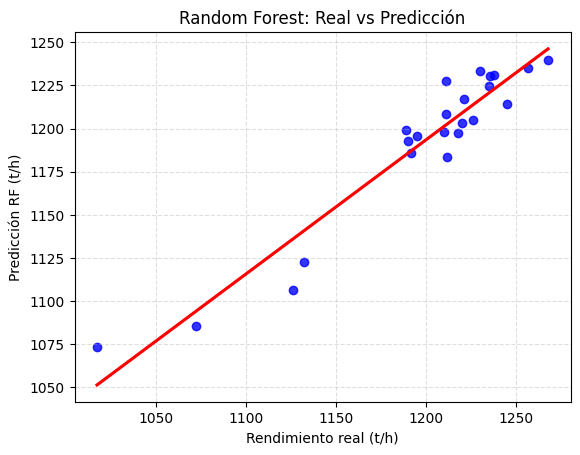

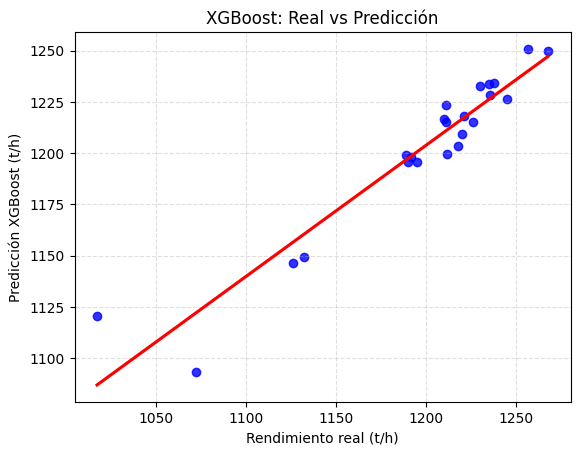

In [12]:

# Random Forest
plt.figure()
sns.regplot(x=y_test, y=rf_pred, color = 'b', ci = None, line_kws={'color': 'r'})
plt.xlabel("Rendimiento real (t/h)")
plt.ylabel("Predicción RF (t/h)")
plt.title("Random Forest: Real vs Predicción")
plt.grid(True, linestyle="--", alpha=0.4)
plt.savefig("salidas_modelo/rf_real_vs_pred.png", bbox_inches="tight")
plt.show()

# XGBoost
if xgb_available:
    plt.figure()
    sns.regplot(x=y_test, y=xgb_pred, color = 'b', ci = None, line_kws={'color': 'r'})
    plt.xlabel("Rendimiento real (t/h)")
    plt.ylabel("Predicción XGBoost (t/h)")
    plt.title("XGBoost: Real vs Predicción")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.savefig("salidas_modelo/xgb_real_vs_pred.png", bbox_inches="tight")
    plt.show()



## 9) Guardar modelos


In [13]:

joblib.dump(rf, "salidas_modelo/modelo_random_forest.pkl")
if xgb_available:
    joblib.dump(xgb, "salidas_modelo/modelo_xgboost.pkl")
print("Modelos guardados en 'salidas_modelo/'.")


Modelos guardados en 'salidas_modelo/'.



## 10) Ejemplo de inferencia


In [14]:

ejemplo = pd.DataFrame({
    "Flujo_agua_m3h": [440],        # <--- reemplaza con tus valores
    "Velocidad_SAG_rpm": [9.0],
    "UGM1": [15],
    "UGM2": [25],
    "UGM3": [60],
    "Porc_Grueso": [20.0],
    "Porc_Intermedio": [50.0],
    "Porc_Fino": [30.0]
})
pred_rf = rf.predict(ejemplo)[0]
print(f"Predicción RF -> {pred_rf:.2f} t/h")
if xgb_available:
    pred_xgb = xgb.predict(ejemplo)[0]
    print(f"Predicción XGB -> {pred_xgb:.2f} t/h")


Predicción RF -> 1184.16 t/h
Predicción XGB -> 1185.61 t/h
